<a href="https://colab.research.google.com/github/rajukr9824/Sustainable-Energy-Forecasting/blob/main/Vanilla_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 24.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, explained_variance_score, max_error

import optuna

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Data Preparation
def prepare_data(filepath, seq_len=24):
    df = pd.read_csv(filepath).iloc[::30, :]
    df['Net Load'] = df['Total Load'] - df['Total PV Gen']
    data = df[['Net Load']].values
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    X, y = np.array(X), np.array(y)

    # Train/Val split
    split = int(0.8 * len(X))
    return X[:split], y[:split], X[split:], y[split:], scaler

In [ ]:
# Transformer Model
class VanillaTransformer(nn.Module):
    def __init__(self, input_dim=1, d_model=32, nhead=2, num_layers=2, dropout=0.1):
        super().__init__()
        self.embed = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embed(x)
        x = self.transformer(x)
        return self.output(x[:, -1, :])

In [ ]:
# Objective function for Optuna
def objective(trial):
    # Hyperparameters to optimize
    d_model = trial.suggest_categorical('d_model', [16, 32, 64])
    nhead = trial.suggest_categorical('nhead', [1, 2, 4])
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.0, 0.3)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    model = VanillaTransformer(d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Data Loaders
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    dataset = TensorDataset(X_train_tensor, y_train_tensor)

    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_data, val_data = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Training loop
    for epoch in range(30):  # Fixed epoch
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_loss += criterion(model(X_batch), y_batch).item()
        trial.report(val_loss / len(val_loader), epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss / len(val_loader)

In [ ]:
# Run Optuna optimization
X_train, y_train, X_test, y_test, scaler = prepare_data('Annual_load_PV.csv')
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2025-04-22 07:10:56,331] A new study created in memory with name: no-name-5a93cbd1-ab2f-45be-bf5d-797208d5b55b
<ipython-input-8-c69038d9bbdd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2025-04-22 07:12:02,089] Trial 0 finished with value: 0.002677482869734781 and parameters: {'d_model': 16, 'nhead': 4, 'num_layers': 2, 'dropout': 0.061933743200769616, 'lr': 5.2298922997129485e-05, 'batch_size': 128}. Best is trial 0 with value: 0.002677482869734781.
[I 2025-04-22 07:16:38,094] Trial 1 finished with value: 0.002717744720634073 and parameters: {'d_model': 32, 'nhead': 4, 'num_layers': 3, 'dropout': 0.29477433015615395, 'lr': 0.00041488124664910525, 'batch_size': 32}. Best is trial 0 with value: 0.002677482869734781.
[I 2025-04-22 07:17:37,445] Trial 2 finished with value

In [ ]:
print("\nBest trial:")
print(study.best_trial)


Best trial:
FrozenTrial(number=2, state=1, values=[0.0025127072086823837], datetime_start=datetime.datetime(2025, 4, 22, 7, 16, 38, 95831), datetime_complete=datetime.datetime(2025, 4, 22, 7, 17, 37, 445169), params={'d_model': 32, 'nhead': 2, 'num_layers': 2, 'dropout': 0.15836298785813127, 'lr': 0.008057035593813133, 'batch_size': 128}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.005609476384485052, 1: 0.006009351646912004, 2: 0.004219914076938515, 3: 0.005982616709338294, 4: 0.004395769820326851, 5: 0.0039230505972805, 6: 0.0030589819745352816, 7: 0.00304590865954875, 8: 0.003600187488787231, 9: 0.0037156969404941987, 10: 0.002973326862538381, 11: 0.0031118892366066575, 12: 0.0035054148359608558, 13: 0.0033473270032407035, 14: 0.0038730132075706645, 15: 0.002566511816685162, 16: 0.0032006638597637887, 17: 0.0029489698908513502, 18: 0.0028316085633363517, 19: 0.002490407644978, 20: 0.0024614183210013877, 21: 0.0024660921042105035, 22: 0.0026469831059258136, 23: 0.00251

In [ ]:
# Train final model with best params and log losses
def train_best_model(params, X_train, y_train, X_test, y_test):
    model = VanillaTransformer(
        d_model=params['d_model'],
        nhead=params['nhead'],
        num_layers=params['num_layers'],
        dropout=params['dropout']
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.MSELoss()

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

    val_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'])

    train_losses = []
    val_losses = []

    for epoch in range(50):
        model.train()
        running_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = sum(criterion(model(X_batch.to(device)), y_batch.to(device)).item() for X_batch, y_batch in val_loader) / len(val_loader)
            val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/50 | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Plot learning curve
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    return model

Epoch 1/50 | Train Loss: 0.0349 | Val Loss: 0.0028
Epoch 2/50 | Train Loss: 0.0038 | Val Loss: 0.0031
Epoch 3/50 | Train Loss: 0.0034 | Val Loss: 0.0030
Epoch 4/50 | Train Loss: 0.0034 | Val Loss: 0.0025
Epoch 5/50 | Train Loss: 0.0032 | Val Loss: 0.0023
Epoch 6/50 | Train Loss: 0.0032 | Val Loss: 0.0026
Epoch 7/50 | Train Loss: 0.0031 | Val Loss: 0.0030
Epoch 8/50 | Train Loss: 0.0030 | Val Loss: 0.0024
Epoch 9/50 | Train Loss: 0.0030 | Val Loss: 0.0024
Epoch 10/50 | Train Loss: 0.0029 | Val Loss: 0.0021
Epoch 11/50 | Train Loss: 0.0029 | Val Loss: 0.0022
Epoch 12/50 | Train Loss: 0.0029 | Val Loss: 0.0023
Epoch 13/50 | Train Loss: 0.0029 | Val Loss: 0.0025
Epoch 14/50 | Train Loss: 0.0028 | Val Loss: 0.0021
Epoch 15/50 | Train Loss: 0.0028 | Val Loss: 0.0022
Epoch 16/50 | Train Loss: 0.0028 | Val Loss: 0.0023
Epoch 17/50 | Train Loss: 0.0028 | Val Loss: 0.0023
Epoch 18/50 | Train Loss: 0.0028 | Val Loss: 0.0022
Epoch 19/50 | Train Loss: 0.0028 | Val Loss: 0.0020
Epoch 20/50 | Train L

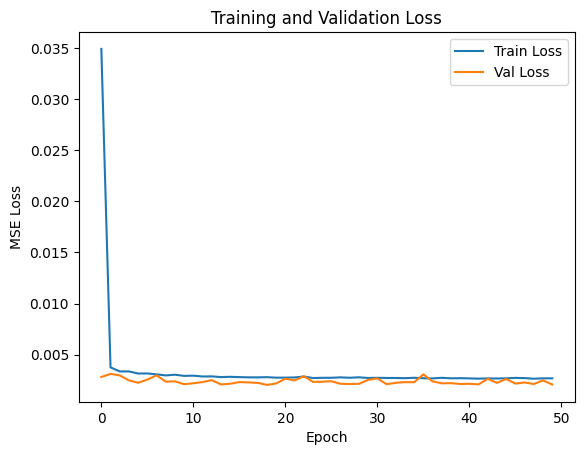

In [ ]:
best_model = train_best_model(study.best_trial.params, X_train, y_train, X_test, y_test)

In [ ]:
def evaluate_model(model, X_test, y_test, scaler, plot_samples=100):
    model.eval()
    with torch.no_grad():
        test_inputs = torch.FloatTensor(X_test).to(device)
        test_outputs = model(test_inputs).cpu().numpy()

    # Inverse transform predictions and actual values
    test_preds = scaler.inverse_transform(test_outputs)
    test_actual = scaler.inverse_transform(y_test)

    # Calculate metrics
    metrics = {
        'MAE': mean_absolute_error(test_actual, test_preds),
        'MSE': mean_squared_error(test_actual, test_preds),
        'RMSE': np.sqrt(mean_squared_error(test_actual, test_preds)),
        'R2': r2_score(test_actual, test_preds),
        'MedAE': median_absolute_error(test_actual, test_preds),
        'Explained Variance': explained_variance_score(test_actual, test_preds),
        'Max Error': max_error(test_actual, test_preds)
    }

    # Print metrics
    print("\nEvaluation Metrics:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}{'%' if name == 'MAPE' else ''}")

    # Plotting
    plt.figure(figsize=(15, 10))

    # Plot first n samples
    plt.subplot(2, 1, 1)
    plt.plot(test_actual, label='Actual', marker='o', markersize=3)
    plt.plot(test_preds, label='Predicted', marker='x', markersize=3)
    plt.title(f'First {plot_samples} Samples Comparison')
    plt.xlabel('Time Steps')
    plt.ylabel('Net Load')
    plt.legend()

    # Scatter plot
    plt.subplot(2, 1, 2)
    plt.scatter(test_actual, test_preds, alpha=0.5)
    plt.plot([min(test_actual), max(test_actual)], [min(test_actual), max(test_actual)], 'r--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    plt.tight_layout()
    plt.show()

    return metrics


Evaluation Metrics:
MAE: 0.3814
MSE: 0.5483
RMSE: 0.7405
R2: 0.8731
MedAE: 0.1554
Explained Variance: 0.8731
Max Error: 6.5768


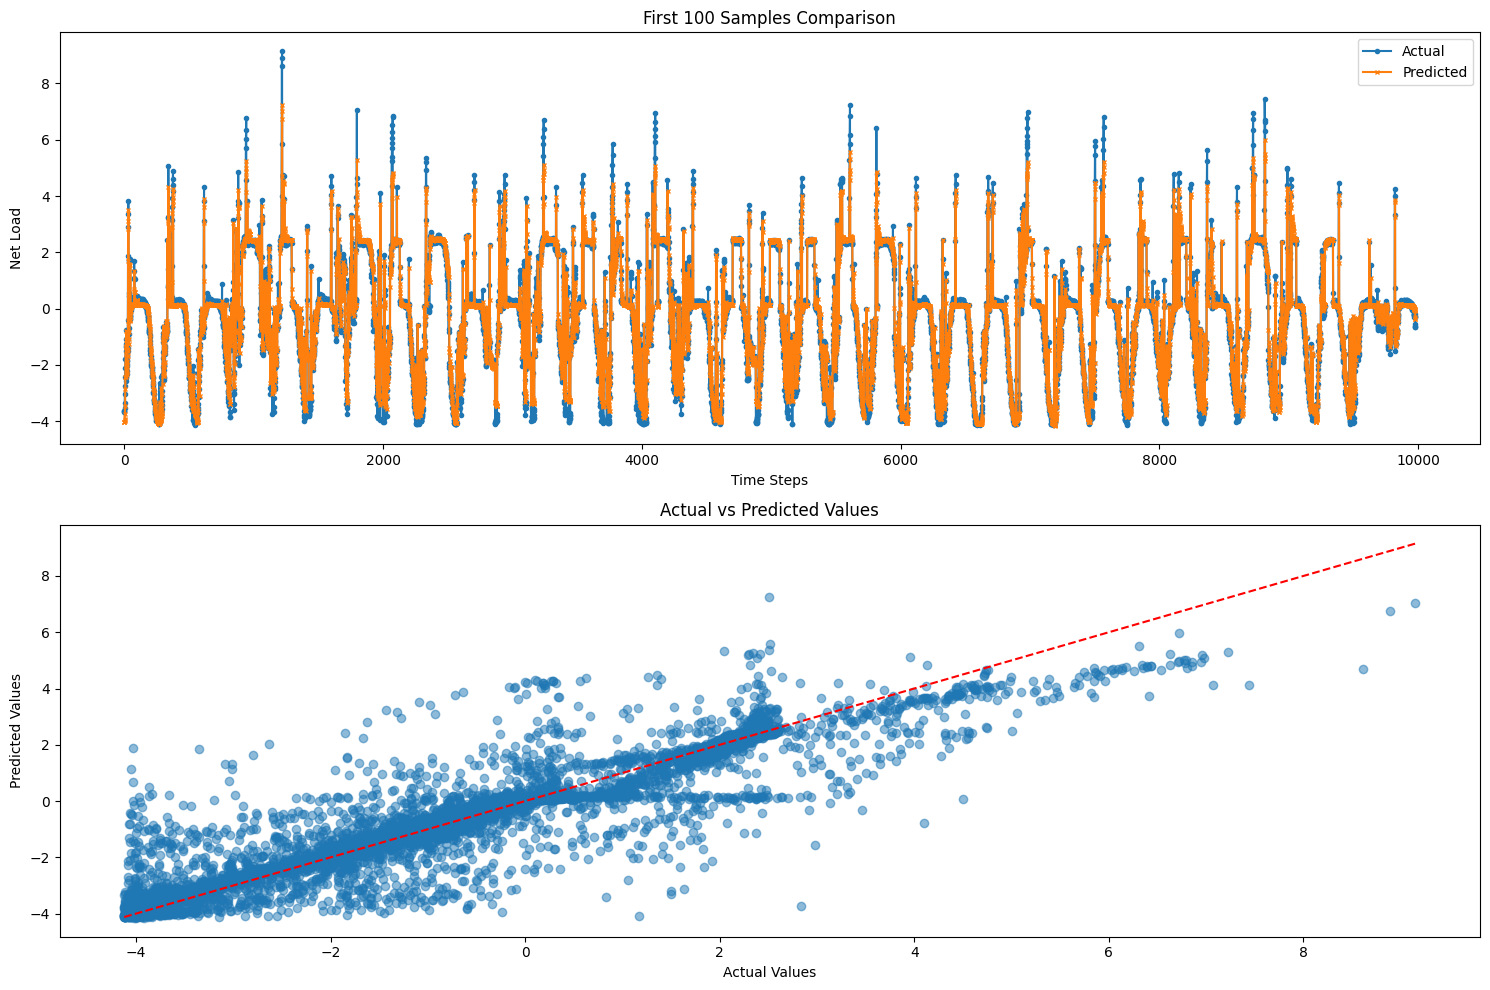

{'MAE': 0.3813518979173135,
 'MSE': 0.5483375715473513,
 'RMSE': np.float64(0.740498191454477),
 'R2': 0.8730650060530589,
 'MedAE': np.float64(0.1554109793305397),
 'Explained Variance': 0.8731285410667003,
 'Max Error': np.float64(6.5768138256073)}

In [ ]:
evaluate_model(best_model,X_test,y_test,scaler,100,)